In [13]:
import os
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
import umap
import matplotlib.pyplot as plt
import scanpy as sc

In [14]:
# -----------------------------
# === USER SETTINGS / PATHS ===
# -----------------------------
H5AD_PATH = "SmallData/xenium_spatial_common_genes.h5ad"   # change if needed

OUT_EMB = "Results_deep_model/xenium_hybrid_graphcl_embeddings.npy"
OUT_UMAP = "Results_deep_model/xenium_hybrid_graphcl_umap.png"

# Graph + model hyperparams (sensible defaults)
knn_spatial = 6
knn_expr = 8
beta = 0.45           # weight on spatial; 1-beta = weight on expression
prune_pct = 0.20      # prune weakest edges globally

edge_drop_prob = 0.15
feat_mask_rate = 0.12
temperature = 0.2

in_hidden = 128
latent_dim = 64
proj_dim = 64
epochs = 500
lr = 2e-3
weight_decay = 1e-6
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

# -----------------------------
# === Data loading & preprocess
# -----------------------------
def load_and_preprocess(spat_path=H5AD_PATH):
    A = sc.read_h5ad(spat_path)
    # find label column if present
    possible_spat_cols = ["broad_cell_type", "cell_type", "predicted_label"]
    spat_label_col = next((c for c in possible_spat_cols if c in A.obs.columns), None)
    if spat_label_col is None:
        print("Warning: no label column found among", possible_spat_cols)
        labels = None
    else:
        labels = A.obs[spat_label_col].astype(str).values

    # normalize total & log1p
    Ac = A.copy()
    sc.pp.normalize_total(Ac, target_sum=1e4)
    sc.pp.log1p(Ac)

    # dense matrix
    X = Ac.X.toarray() if hasattr(Ac.X, "toarray") else Ac.X
    X = X.astype(np.float32)

    # Important: standardize per gene
    scaler = StandardScaler()
    X = scaler.fit_transform(X).astype(np.float32)

    y_id = None
    label_map = None
    if labels is not None:
        all_labels = np.unique(labels)
        label_map = {lab: i for i, lab in enumerate(all_labels)}
        y_id = np.array([label_map[l] for l in labels], dtype=np.int64)

    if "spatial" not in Ac.obsm_keys():
        raise RuntimeError("Spatial coords key 'spatial' not found in A.obsm.")
    coords = Ac.obsm["spatial"].astype(np.float32)

    return X, coords, y_id, label_map

# -----------------------------
# === Graph builders ==========
# -----------------------------
def build_mutual_knn_weighted(coords_np, k=8, prune_pct=0.25, device=None):
    # coords_np: (n,2)
    coords = torch.from_numpy(coords_np).float()
    if device:
        coords = coords.to(device)
    n = coords.size(0)
    dists = torch.cdist(coords, coords)  # (n,n)
    dists.fill_diagonal_(float('inf'))
    knn_idx = torch.topk(dists, k=k, largest=False).indices  # (n,k)
    knn_lists = [set(knn_idx[i].cpu().tolist()) for i in range(n)]
    edges = set()
    for u in range(n):
        for v in knn_idx[u].cpu().tolist():
            if u in knn_lists[v]:
                a,b = (u,v) if u<v else (v,u)
                edges.add((a,b))
    # fallback: if mutual no edges, use symmetric kNN
    if len(edges) == 0:
        for u in range(n):
            for v in knn_idx[u].cpu().tolist():
                a,b = (u,v) if u<v else (v,u)
                edges.add((a,b))

    kth = dists[torch.arange(n), knn_idx[:, -1]]
    sigma = float(kth.median().item())
    if sigma <= 0: sigma = 1.0

    A = torch.zeros((n,n), dtype=torch.float32)
    for (u,v) in edges:
        dist = float(torch.dist(coords[u], coords[v]).item())
        w = float(np.exp(- (dist**2) / (2.0 * (sigma**2) + 1e-12)))
        A[u,v] = w; A[v,u] = w

    if prune_pct > 0:
        weights = A[A>0].numpy()
        if len(weights) > 0:
            thresh = np.percentile(weights, prune_pct*100)
            A[A < thresh] = 0.0

    return A

def build_expression_knn(X_np, k=12, device=None):
    # X_np: (n, g) standardized
    # use PCA to denoise
    pca = PCA(n_components=min(50, X_np.shape[1]), random_state=seed)
    Xp = pca.fit_transform(X_np)
    Xnorm = Xp / (np.linalg.norm(Xp, axis=1, keepdims=True) + 1e-12)
    Xnorm_t = torch.from_numpy(Xnorm).float()
    if device:
        Xnorm_t = Xnorm_t.to(device)
    sim = (Xnorm_t @ Xnorm_t.t()).cpu()  # (n,n)
    n = sim.size(0)
    A = torch.zeros((n,n), dtype=torch.float32)
    _, idx = torch.topk(sim, k=k+1, dim=1)  # includes self
    for i in range(n):
        for j in idx[i,1:].tolist():  # skip self
            A[i,j] = float(sim[i,j].item())
            A[j,i] = float(sim[i,j].item())
    return A

def combine_hybrid(A_sp, A_expr, beta=0.5, prune_pct=0.25):
    A = beta * A_sp + (1.0 - beta) * A_expr
    vals = A[A>0].numpy()
    if len(vals) > 0 and prune_pct > 0:
        thresh = np.percentile(vals, prune_pct*100)
        A[A < thresh] = 0.0
    return A

def normalize_adj(A):
    # A: torch dense
    n = A.size(0)
    A_hat = A + torch.eye(n)
    deg = A_hat.sum(dim=1)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[torch.isinf(deg_inv_sqrt)] = 0.0
    D_inv_sqrt = torch.diag(deg_inv_sqrt)
    return D_inv_sqrt @ A_hat @ D_inv_sqrt

# -----------------------------
# === Model: encoder + proj ===
# -----------------------------
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim, bias=True)
    def forward(self, X, A_norm):
        return F.relu(self.linear(A_norm @ X))

class GCNEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, latent_dim):
        super().__init__()
        self.gcn1 = GCNLayer(in_dim, hidden_dim)
        self.gcn2 = GCNLayer(hidden_dim, latent_dim)
    def forward(self, X, A_norm):
        h = self.gcn1(X, A_norm)
        z = self.gcn2(h, A_norm)
        return z

class ProjectionHead(nn.Module):
    def __init__(self, in_dim, proj_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.ReLU(),
            nn.Linear(in_dim, proj_dim)
        )
    def forward(self, x):
        return self.net(x)

# -----------------------------
# === Augmentations ===========
# -----------------------------
def drop_edges(A, drop_prob):
    if drop_prob <= 0:
        return A.clone()
    A2 = A.clone()
    # unique undirected edges via upper triangle
    tri_u, tri_v = torch.triu_indices(A2.size(0), A2.size(1), offset=1)
    mask = (A2[tri_u, tri_v] > 0)
    tri_u = tri_u[mask]; tri_v = tri_v[mask]
    num_edges = tri_u.size(0)
    keep = max(1, int((1.0 - drop_prob) * num_edges))
    perm = torch.randperm(num_edges)[:keep]
    keep_u = tri_u[perm]; keep_v = tri_v[perm]
    A_new = torch.zeros_like(A2)
    A_new[keep_u, keep_v] = A2[keep_u, keep_v]
    A_new[keep_v, keep_u] = A2[keep_u, keep_v]
    return A_new

def mask_features(X, mask_rate):
    if mask_rate <= 0:
        return X.clone()
    X2 = X.clone()
    n, g = X2.size()
    num_mask = int(mask_rate * g)
    if num_mask <= 0:
        return X2
    for i in range(n):
        idx = torch.randperm(g)[:num_mask]
        X2[i, idx] = 0.0
    return X2

# -----------------------------
# === Contrastive loss ========
# -----------------------------
def nt_xent_loss(z1, z2, temperature=0.2):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    batch_size = z1.size(0)
    z = torch.cat([z1, z2], dim=0)
    sim = (z @ z.t()) / temperature
    mask = (~torch.eye(2*batch_size, dtype=torch.bool, device=sim.device)).float()
    positives = torch.cat([torch.diag(sim, batch_size), torch.diag(sim, -batch_size)], dim=0)
    exp_sim = torch.exp(sim) * mask
    denom = exp_sim.sum(dim=1)
    loss = - torch.log(torch.exp(positives) / (denom + 1e-15))
    return loss.mean()

# -----------------------------
# === Training GraphCL =======
# -----------------------------
def train_graphcl_hybrid(X_np, coords_np, y_np=None):
    X = torch.from_numpy(X_np).float().to(device)
    coords = coords_np
    n = X.shape[0]

    # Build graphs
    A_sp = build_mutual_knn_weighted(coords, k=knn_spatial, prune_pct=0.0, device=device)
    A_expr = build_expression_knn(X_np, k=knn_expr, device=device)
    A_hybrid = combine_hybrid(A_sp, A_expr, beta=beta, prune_pct=prune_pct)
    degs = (A_hybrid > 0).sum(dim=1).float()
    print(f"Hybrid built: avg deg {degs.mean().item():.2f} (min {degs.min().item()}, max {degs.max().item()})")

    # normalize adjacency for GCN
    A_norm = normalize_adj(A_hybrid).to(device)

    # model
    encoder = GCNEncoder(in_dim=X.shape[1], hidden_dim=in_hidden, latent_dim=latent_dim).to(device)
    proj = ProjectionHead(latent_dim, proj_dim).to(device)
    opt = torch.optim.Adam(list(encoder.parameters()) + list(proj.parameters()), lr=lr, weight_decay=weight_decay)

    best_loss = 1e9; patience_cnt = 0; patience = 80

    for epoch in range(1, epochs+1):
        encoder.train(); proj.train()
        opt.zero_grad()

        # Aug views
        A1 = drop_edges(A_hybrid, drop_prob=edge_drop_prob).to(device)
        A1_norm = normalize_adj(A1).to(device)
        X1 = mask_features(X, mask_rate=feat_mask_rate)

        A2 = drop_edges(A_hybrid, drop_prob=edge_drop_prob).to(device)
        A2_norm = normalize_adj(A2).to(device)
        X2 = mask_features(X, mask_rate=feat_mask_rate)

        z1 = encoder(X1, A1_norm)   # (n, latent)
        z2 = encoder(X2, A2_norm)
        p1 = proj(z1)
        p2 = proj(z2)

        loss = nt_xent_loss(p1, p2, temperature=temperature)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(proj.parameters()), max_norm=5.0)
        opt.step()

        if epoch % 25 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | loss {loss.item():.4f}")

        if loss.item() < best_loss - 1e-6:
            best_loss = loss.item(); patience_cnt = 0
            torch.save({'enc': encoder.state_dict(), 'proj': proj.state_dict()}, 'best_hybrid_graphcl.pt')
        else:
            patience_cnt += 1
            if patience_cnt >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    # load best
    try:
        ckpt = torch.load('best_hybrid_graphcl.pt', map_location=device)
        encoder.load_state_dict(ckpt['enc'])
        proj.load_state_dict(ckpt['proj'])
    except Exception:
        pass

    encoder.eval()
    with torch.no_grad():
        Z = encoder(X, A_norm).cpu().numpy()

    np.save(OUT_EMB, Z)
    print("Saved embeddings to", OUT_EMB)

    # evaluations
    print("Silhouette scores by k:")
    for k in [4,6,8,10]:
        try:
            km = KMeans(n_clusters=k, random_state=seed, n_init=20).fit(Z)
            sil = silhouette_score(Z, km.labels_)
            print(f"  k={k}: silhouette {sil:.4f}")
        except Exception as e:
            print("  k failed", e)

    if y_np is not None:
        nclusters = len(np.unique(y_np))
        km = KMeans(n_clusters=nclusters, random_state=seed, n_init=20).fit(Z)
        ari = adjusted_rand_score(y_np, km.labels_)
        nmi = normalized_mutual_info_score(y_np, km.labels_)
        print("ARI:", ari, "NMI:", nmi)

    # UMAP
    reducer = umap.UMAP(n_neighbors=10, min_dist=0.0, random_state=seed)
    Z_umap = reducer.fit_transform(Z)
    plt.figure(figsize=(6,5))
    if y_np is not None:
        plt.scatter(Z_umap[:,0], Z_umap[:,1], c=y_np, s=8, cmap='tab10')
    else:
        plt.scatter(Z_umap[:,0], Z_umap[:,1], s=8)
    plt.title("Hybrid GraphCL UMAP")
    plt.tight_layout()
    plt.savefig(OUT_UMAP, dpi=200)
    plt.show()
    print("Saved UMAP to", OUT_UMAP)

    # map clusters back to spatial coords (KMeans)
    try:
        km = KMeans(n_clusters=max(2, len(np.unique(y_np)) if y_np is not None else 6), random_state=seed, n_init=20).fit(Z)
        plt.figure(figsize=(6,5))
        plt.scatter(coords[:,0], coords[:,1], c=km.labels_, s=8, cmap='tab10')
        plt.title("KMeans on hybrid GraphCL Z mapped to coords")
        plt.show()
    except Exception:
        pass

    return Z


/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


Hybrid built: avg deg 13.84 (min 0.0, max 56.0)
Epoch    1 | loss 8.2088
Epoch   25 | loss 5.0376
Epoch   50 | loss 4.3849
Epoch   75 | loss 4.1766
Epoch  100 | loss 4.0771
Epoch  125 | loss 4.0219
Epoch  150 | loss 3.9821
Epoch  175 | loss 3.9553
Epoch  200 | loss 3.9382
Epoch  225 | loss 3.9183
Epoch  250 | loss 3.9077
Epoch  275 | loss 3.9014
Epoch  300 | loss 3.8819
Epoch  325 | loss 3.8733
Epoch  350 | loss 3.8702
Epoch  375 | loss 3.8598
Epoch  400 | loss 3.8532
Epoch  425 | loss 3.8520
Epoch  450 | loss 3.8431
Epoch  475 | loss 3.8420
Epoch  500 | loss 3.8401
Saved embeddings to Results_deep_model/xenium_hybrid_graphcl_embeddings.npy
Silhouette scores by k:
  k=4: silhouette 0.1994
  k=6: silhouette 0.2146
  k=8: silhouette 0.2119
  k=10: silhouette 0.1833
ARI: 0.37454296790584013 NMI: 0.4722559916386741


/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


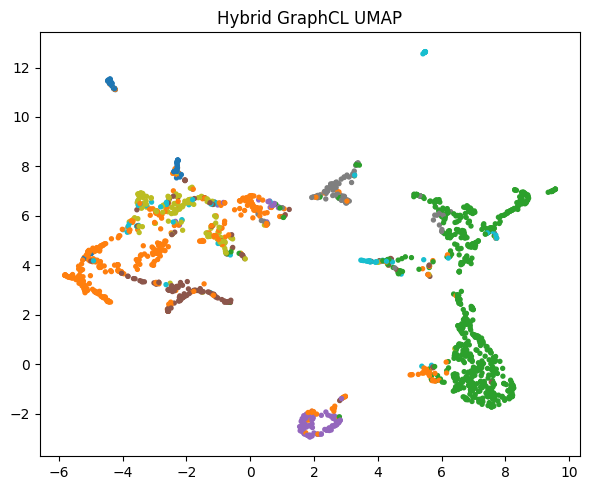

Saved UMAP to Results_deep_model/xenium_hybrid_graphcl_umap.png


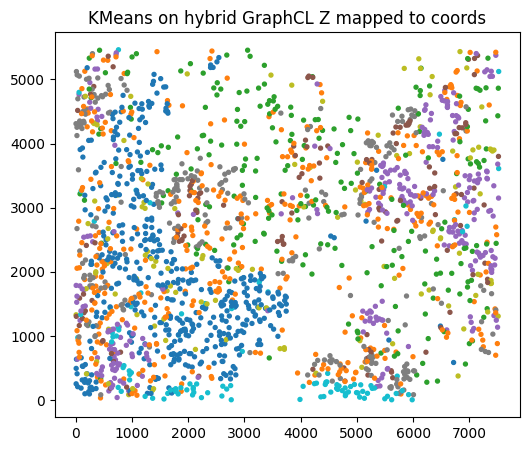

Done. Embeddings shape: (2000, 64)


In [15]:
X, coords, y_id, label_map = load_and_preprocess(H5AD_PATH)
Z = train_graphcl_hybrid(X, coords, y_id)
print("Done. Embeddings shape:", Z.shape)